## DeepONet: Learning diffusivity (m) to solution (u) map for the Poisson problem

In [1]:
import sys
import os

import torch
from torch.nn.utils import parameters_to_vector
import numpy as np

src_path = "../../src/"
sys.path.append(src_path + 'plotting/')
from field_plot import field_plot 
from plot_loss import plot_loss 

sys.path.append(src_path + 'data/')
from dataMethods import DataProcessor 

sys.path.append(src_path + 'nn/deeponet/')
sys.path.append(src_path + 'nn/mlp/')
sys.path.append(src_path + 'uq/')
from torch_deeponet import DeepONet 
import uq_deeponet as uq
import uq_evaluation as uq_eval

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# set seed
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
data_folder = '../../../autodl-tmp/data/'
results_dir = data_folder
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

## Load data

In [3]:
num_train = 3500
num_test = 1000

num_inp_fn_points = 2601 # number of grid points for the input function
num_out_fn_points = 2601 # number of evaluations points for the output function
num_Y_components = 1 # scalar field
num_tr_outputs = 100 # number of outputs from the trunk network before they are multiplied
num_br_outputs = 100 # number of outputs from the branch and trunk networks before they are multiplied
out_coordinate_dimension = 2 # domain for output function is 2D


# training hyperparameters
batch_size = 20
epochs = 1000
lr = 1.0e-3
act_fn = torch.nn.GELU()
 
data_prefix = 'Poisson'

data = DataProcessor(data_folder + data_prefix + '_samples_.npz', num_train, num_test, num_inp_fn_points, num_out_fn_points, num_Y_components)
train_data = {'X_train': data.X_train, 'X_trunk': data.X_trunk, 'Y_train': data.Y_train}
test_data = {'X_train': data.X_test, 'X_trunk': data.X_trunk, 'Y_train': data.Y_test}

print('X_train:',data.X_train.shape)
print('Y_train:',data.Y_train.shape)
print('X_test:',data.X_test.shape)
print('Y_test:',data.Y_test.shape)
print('X_trunk:',data.X_trunk.shape)

X_train: (3500, 2601)
Y_train: (3500, 2601)
X_test: (1000, 2601)
Y_test: (1000, 2601)
X_trunk: (2601, 2)


In [4]:
num_test_shift = 400
# Shifting data sets
data_type=[['no-ood',0.005,0.2,1,0],['ood-1',0.0005,0.2,1,0],['ood-2',0.001,0.2,1,0],\
           ['ood-3',0.01,0.2,1,0],['ood-4',0.05,0.2,1,0],['ood-5',0.1,0.2,1,0], \
            ['ood-6',0.5,0.2,1,0]]
data_shifting = []
data_shifting_data = []
for datatype in data_type:
    data_shifting.append(DataProcessor(data_folder + data_prefix + f'_samples_{datatype[0]}.npz', 100, 400, num_inp_fn_points, num_out_fn_points, num_Y_components))
    data_shifting_data.append({'X_train': data_shifting[-1].X_test, 'X_trunk': data_shifting[-1].X_trunk, 'Y_train': data_shifting[-1].Y_test})

## Create model and train the network

In [5]:
num_layers = 3
num_neurons = 64

model_save_path = results_dir + 'DeepONet/'
model_save_file = model_save_path + 'model.pkl'
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

model = DeepONet(num_layers, num_neurons, act_fn, num_br_outputs, \
                 num_tr_outputs, num_inp_fn_points, \
                 out_coordinate_dimension, num_Y_components,\
                 save_file = model_save_file)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters: {}'.format(trainable_params))

Using device: cuda
Number of trainable parameters: 188041


In [ ]:
# save the data and info
data_to_save = data.get_data_to_save()
model_metadata = {  'data': data_to_save, \
                    'num_train': num_train, \
                    'num_test': num_test, \
                    'num_inp_fn_points': num_inp_fn_points, \
                    'num_out_fn_points': num_out_fn_points, \
                    'num_Y_components': num_Y_components, \
                    'num_tr_outputs': num_tr_outputs, \
                    'num_br_outputs': num_br_outputs, \
                    'out_coordinate_dimension': out_coordinate_dimension, \
                    'num_layers': num_layers, \
                    'num_neurons': num_neurons, \
                    'epochs': epochs, \
                    'batch_size': batch_size, \
                    'lr': lr}
# attach it to the model
model.metadata = model_metadata

In [ ]:
# Train
model.train(train_data, test_data, batch_size=batch_size, \
            epochs = epochs, lr = lr, \
            save_model = True, save_epoch = 100)

In [ ]:
plot_loss( model.train_loss_log[:, 0], \
           model.test_loss_log[:, 0], \
           fs = 14, lw = 2, \
           savefile = results_dir+'loss_his.png', \
           figsize = [6,6])

## Test and plot the output of network

In [ ]:
# load the model
model = torch.load(model_save_file, weights_only=False)

sfname = model_save_file.split(os.path.sep)
print('-'*50)
print('Model loaded from: {}'.format(sfname[-2] + '/' + sfname[-1]))
print('\n' + '-'*50)
print('Model metadata:', model.metadata.keys())
print('\n' + '-'*50)
print('Model:', model)

In [ ]:
Y_test = test_data['Y_train']
Y_test_pred = model.predict(test_data['X_train'], test_data['X_trunk']).detach().cpu().numpy()
print('test_out shape: {}, test_pred shape: {}'.format(Y_test.shape, Y_test_pred.shape))
error = np.linalg.norm(Y_test - Y_test_pred, axis = 1)/np.linalg.norm(Y_test, axis = 1)
print('Num tests: {:5d}, Mean Loss (rel l2): {:.3e}, Std Loss (rel l2): {:.3e}'.format(num_test, np.mean(error), np.std(error)))

In [ ]:
def apply_dirichlet_bc(u, bc_value, bc_node_ids):
    u[bc_node_ids] = bc_value
    return u

In [ ]:
rows, cols = 4, 4
fs = 20
fig, axs = plt.subplots(rows, cols, figsize=(16, 13))

decode = True
apply_dirichlet_bc_flag = True

# row: m, u_true, u_pred, u_diff
u_tags = [r'$m$', r'$u_{true}$', r'$u_{pred}$', r'$u_{true} - u_{pred}$']
cmaps = ['jet', 'viridis', 'viridis', 'hot']

nodes = data.X_trunk 

# randomly choose rows number of samples
i_choices = np.random.choice(num_test, rows, replace=False)

for i in range(rows):
    
    i_plot = i_choices[i]

    i_pred = Y_test_pred[i_plot]
    i_truth = Y_test[i_plot]
    i_m_test = data.X_test[i_plot]
    if decode:
        i_pred = data.decoder_Y(i_pred)
        i_truth = data.decoder_Y(i_truth)
        i_m_test = data.decoder_X(i_m_test)
    if apply_dirichlet_bc_flag:
        i_pred = apply_dirichlet_bc(i_pred, 0.0, data.u_mesh_dirichlet_boundary_nodes)
        # verify for i_truth
        if np.abs(i_truth[data.u_mesh_dirichlet_boundary_nodes]).max() > 1.0e-9:
            print('Warning: Dirichlet BC not applied to i_truth. Err : {}'.format(np.abs(i_truth[data.u_mesh_dirichlet_boundary_nodes]).max()))

            
    i_diff = i_pred - i_truth
    i_diff_norm = np.linalg.norm(i_diff) / np.linalg.norm(i_truth)
    print('i_plot = {:5d}, error (rel l2): {:.3e}'.format(i_plot, i_diff_norm))

    uvec = [i_m_test, i_truth, i_pred, i_diff]
    
    for j in range(cols):
        
        cbar = field_plot(axs[i,j], uvec[j], nodes, cmap = cmaps[j])

        divider = make_axes_locatable(axs[i,j])
        cax = divider.append_axes('right', size='8%', pad=0.03)
        cax.tick_params(labelsize=fs)

        if j == 0 or j == cols - 1:
            # format cbar ticks
            kfmt = lambda x, pos: "{:g}".format(x)
            
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical', format = kfmt)
        else:
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical')

        if i == 0 and j < cols - 1:
            axs[i,j].set_title(u_tags[j], fontsize=fs)
        
        if j == cols - 1:
            err_str = 'err (rel l2): {:.3f}%'.format(i_diff_norm*100)
            if i == 0:
                err_str = u_tags[j] + '\n' + err_str
            axs[i,j].set_title(err_str, fontsize=fs)

        axs[i,j].axis('off')

fig.tight_layout()
fig.suptitle('Poisson problem: Compare neural operator predictions ({})'.format(model.name), fontsize=1.25*fs, y=1.025)
fig.savefig(results_dir+'neural_operator_prediction_comparison.png',  bbox_inches='tight')
plt.show()


## Uncertainty Quantification Sampling

## HMC

In [7]:
model = torch.load(model_save_file, weights_only=False)
model.to(device)
# Keep a copy of the full model state for reconstruction
base_state = {k: v.detach().clone() for k, v in model.state_dict().items()}
all_params = list(model.parameters())

num_hmc_samples_data = 1000 
hmc_indices = np.random.choice(num_train, num_hmc_samples_data, replace=False)
x_branch_hmc = train_data['X_train'][hmc_indices]
x_trunk_hmc = train_data['X_trunk']
y_hmc = train_data['Y_train'][hmc_indices]
print(f"Using {num_hmc_samples_data} TRAINING samples for HMC")

model, flat0, prior_std = uq.freezelayer(model, device)
noise_std = 0.2
log_prob = uq.make_log_prob_fn(model, x_branch_hmc, x_trunk_hmc, y_hmc, noise_std=noise_std, prior_std=prior_std)

# Adaptive hmc settings
hmc_num_samples = 5000
hmc_burn_in = 4900     
hmc_initial_step_size = 1e-4 # Start larger now that surface is smoother
hmc_leapfrog_steps = 20

hmc_samples = uq.hmc_nuts(
    log_prob, 
    flat0.requires_grad_(True), 
    initial_step_size=hmc_initial_step_size, 
    leapfrog_steps=hmc_leapfrog_steps, 
    num_samples=hmc_num_samples, 
    burn_in=hmc_burn_in
)
# Reconstruct full-parameter vectors so downstream code can load complete models
hmc_samples_full = torch.stack([uq.build_full_vector(model, base_state, all_params, s.detach()) for s in hmc_samples])
torch.save(hmc_samples_full, model_save_path + 'hmc_samples.pt')

Using 1000 TRAINING samples for HMC
Trainable params: 13001
Initial parameter vector shape (trainable only): torch.Size([13001])
Initial last-layer param std (scalar): 7.139e-02
Starting HMC with hamiltorch...
  Samples: 5000 + Burn-in: 4900
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
Final Adapted Step Size:  1.0231777736180447e-07 | 4892/5000 | 70.35       
0d:00:01:10 | 0d:00:00:00 | #################### | 5000/5000 | 70.56       
Acceptance Rate 0.79


Starting HMC with hamiltorch...
  Samples: 5000 + Burn-in: 4900
Sampling (Sampler.HMC; Integrator.IMPLICIT)


Time spent  | Time remain.| Progress             | Samples   | Samples/sec
Final Adapted Step Size:  9.198738837312703e-08# | 4891/5000 | 50.59       
0d:00:01:38 | 0d:00:00:00 | #################### | 5000/5000 | 50.55       
Acceptance Rate 0.78
Combined posterior shape: (2, 100, 10, 10)
Computing diagnostics...

--- Diagnostic Statistics (R-hat, ESS) ---
           r_hat    ess_bulk    ess_tail
count  100.00000  100.000000  100.000000
mean     2.35150    2.940000   15.100000
std      0.32523    0.277798    2.862153
min      1.56000    2.000000   11.000000
25%      2.13750    3.000000   13.000000
50%      2.32000    3.000000   14.000000
75%      2.59500    3.000000   17.000000
max      2.97000    4.000000   22.000000

Number of parameters with R-hat > 1.05: 100 / 100

Visualizing trace and rank plots for the first 6 parameters:


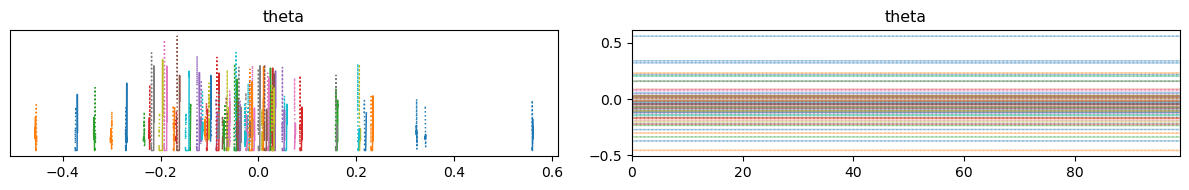

/root/miniconda3/envs/neuralop/lib/python3.12/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (70) in plot_rank, generating only 40 plots
  warnings.warn(


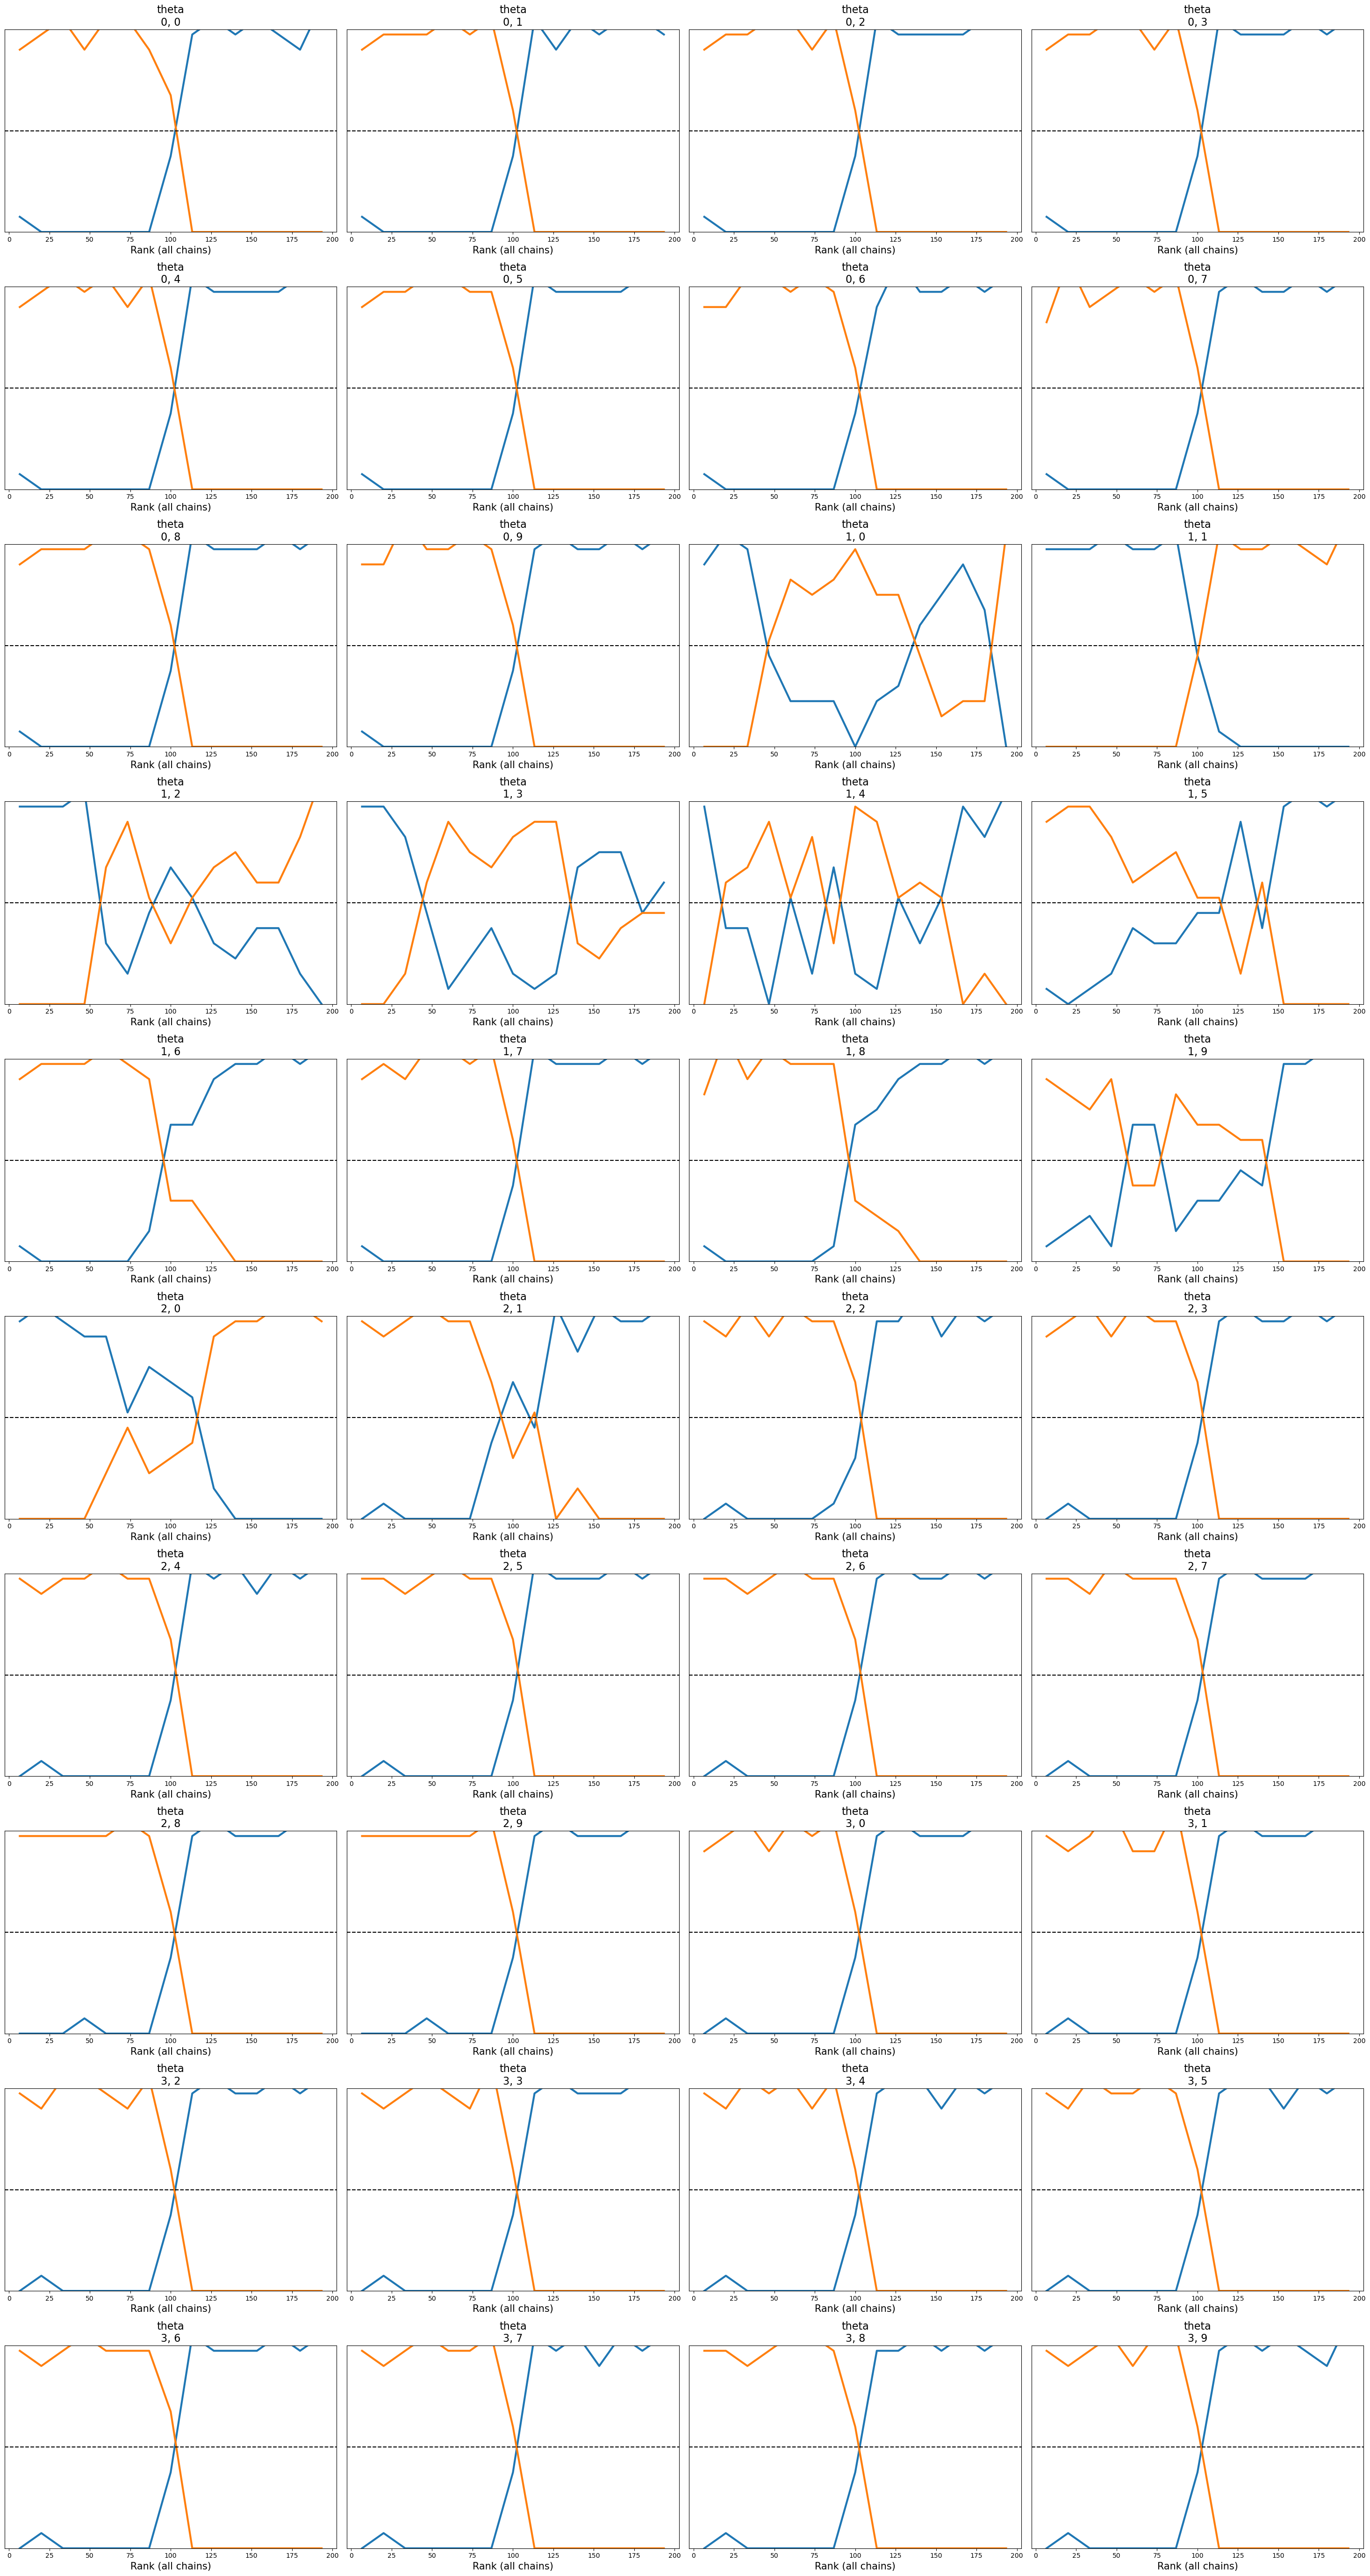

In [ ]:
hmc_samples_2 = uq.hmc_nuts(
    log_prob, 
    flat0.requires_grad_(True), 
    initial_step_size=hmc_initial_step_size, 
    leapfrog_steps=hmc_leapfrog_steps, 
    num_samples=hmc_num_samples, 
    burn_in=hmc_burn_in,
    random_seed=84
)
hmc_samples_full_2 = torch.stack([uq.build_full_vector(model, base_state, all_params, s.detach()) for s in hmc_samples_2])

model = torch.load(model_save_file, weights_only=False)
model.to(device)

eval_indices = np.random.choice(len(test_data["X_train"]), 10, replace=False)
eval_indices.sort()
x_branch_eval = test_data['X_train'][eval_indices]
x_trunk_eval = test_data['X_trunk']
y_eval = test_data['Y_train'][eval_indices]

with torch.no_grad():
    preds_eval_list = []
    for idx, s in enumerate(hmc_samples_full): # pyright: ignore[reportArgumentType]
        uq.unpack_params(model, s.to(device))
        x_b = torch.from_numpy(x_branch_eval).float().to(device)
        x_t = torch.from_numpy(x_trunk_eval).float().to(device)
        pred = model.predict(x_b, x_t)
        preds_eval_list.append(pred.cpu().numpy())
preds_eval = np.stack(preds_eval_list)[:,:,:10]

with torch.no_grad():
    preds_eval_list_2 = []
    for idx, s in enumerate(hmc_samples_full_2): # pyright: ignore[reportArgumentType]
        uq.unpack_params(model, s.to(device))
        x_b = torch.from_numpy(x_branch_eval).float().to(device)
        x_t = torch.from_numpy(x_trunk_eval).float().to(device)
        pred = model.predict(x_b, x_t)
        preds_eval_list_2.append(pred.cpu().numpy())
preds_eval_2 = np.stack(preds_eval_list_2)[:,:,:10]


import arviz as az

# 1. Prepare data: Stack chains into shape (chains, draws, parameters)
# Detach and move to CPU to ensure numpy conversion works
chain_0 = preds_eval
chain_1 = preds_eval_2

# Stack along a new dimension for chains: shape becomes (2, num_samples, num_params)
posterior_draws = np.stack([chain_0, chain_1], axis=0)

print(f"Combined posterior shape: {posterior_draws.shape}")

# 2. Create ArviZ InferenceData object
# We treat the flattened parameter vector as a single variable named "theta"
idata = az.from_dict(posterior={"theta": posterior_draws})

# 3. Compute Summary Statistics (R-hat, ESS)
# Note: Computing this for all parameters might be slow if the model is large.
# We display a statistical summary of the diagnostics rather than the full table.
print("Computing diagnostics...")
summary_stats = az.summary(idata)

print("\n--- Diagnostic Statistics (R-hat, ESS) ---")
print(summary_stats[["r_hat", "ess_bulk", "ess_tail"]].describe())

# Count non-converged parameters
rhat_threshold = 1.05
non_converged = (summary_stats['r_hat'] > rhat_threshold).sum()
print(f"\nNumber of parameters with R-hat > {rhat_threshold}: {non_converged} / {len(summary_stats)}")

# 4. Visual Diagnostics
# Plot Trace and Rank plots for the first few parameters to inspect mixing
num_plot_params = 6
print(f"\nVisualizing trace and rank plots for the first {num_plot_params} parameters:")

az.plot_trace(idata, var_names=["theta"], coords={"theta_dim_0": slice(0, num_plot_params)})
plt.tight_layout()
plt.show()

# Rank plots are excellent for assessing if chains have mixed well (should look uniform)
az.plot_rank(idata, var_names=["theta"], coords={"theta_dim_0": slice(0, num_plot_params)}, kind="vlines",
             vlines_kwargs={'lw':0}, marker_vlines_kwargs={'lw':3})
plt.tight_layout()
plt.show()

## SGLD

In [8]:
model = torch.load(model_save_file, weights_only=False)
model.to(device)
# Keep a copy of the full model state for reconstruction
base_state = {k: v.detach().clone() for k, v in model.state_dict().items()}
all_params = list(model.parameters())

# Also use a subset for SGLD or full training data with mini-batching
x_branch_sgld = train_data['X_train'] # Use training data
x_trunk_sgld = train_data['X_trunk']
y_sgld = train_data['Y_train']        # Use training data

# SGLD Sampling Parameters
num_samples = 10000    # Number of posterior samples to collect
burn_in = 2000         # Burn-in iterations
step_size = 1e-6       # Initial step size for SGLD
step_decay = 0.9995    # Step size decay per iteration
min_step_size = 1e-9   # Minimum step size
sgld_batch_size = 100  # Mini-batch size for memory efficiency
slices = 100           # Thinning factor to reduce autocorrelation in samples

model, flat0, prior_std = uq.freezelayer(model, device)
noise_std = 0.2

# Create log probability function
log_prob_fn = uq.make_minibatch_log_prob_fn(
    model, x_branch_sgld, x_trunk_sgld, y_sgld,
    batch_size=sgld_batch_size,
    prior_std=prior_std,
    noise_std=noise_std,
)
# Run SGLD
print("Running SGLD sampling...")
sgld_samples, final_step_size = uq.sgld(
    log_prob_fn,
    flat0,
    step_size=step_size,
    num_samples=num_samples,
    burn_in=burn_in,
    step_decay=step_decay,
    min_step_size=min_step_size
)
sgld_samples = sgld_samples[::slices]
print(f"SGLD completed. Final step size: {final_step_size:.2e}")
print(f"Number of samples collected: {len(sgld_samples)}")
sgld_samples_full = torch.stack([uq.build_full_vector(model, base_state, all_params, s.detach()) for s in sgld_samples])
torch.save(sgld_samples_full, model_save_path + 'sgld_samples.pt')

Trainable params: 13001
Initial parameter vector shape (trainable only): torch.Size([13001])
Initial last-layer param std (scalar): 7.139e-02
Running SGLD sampling...
Starting SGLD sampling...
  Burn-in: 2000, Samples: 10000
  Initial step size: 1.00e-06
Iter  100/12000: step_size = 9.51e-07, phase = burn-in
Iter  200/12000: step_size = 9.05e-07, phase = burn-in
Iter  300/12000: step_size = 8.61e-07, phase = burn-in
Iter  400/12000: step_size = 8.19e-07, phase = burn-in
Iter  500/12000: step_size = 7.79e-07, phase = burn-in
Iter  600/12000: step_size = 7.41e-07, phase = burn-in
Iter  700/12000: step_size = 7.05e-07, phase = burn-in
Iter  800/12000: step_size = 6.70e-07, phase = burn-in
Iter  900/12000: step_size = 6.38e-07, phase = burn-in
Iter 1000/12000: step_size = 6.06e-07, phase = burn-in
Iter 1100/12000: step_size = 5.77e-07, phase = burn-in
Iter 1200/12000: step_size = 5.49e-07, phase = burn-in
Iter 1300/12000: step_size = 5.22e-07, phase = burn-in
Iter 1400/12000: step_size = 4

## Monte-Carlo Dropout

In [ ]:
# It suffices to sample when evaluating.

## Laplacian Approximation

In [9]:
# Laplace Approximation (sample last layer only, save full model vectors)
model = torch.load(model_save_file, weights_only=False)
model.to(device)
base_state = {k: v.detach().clone() for k, v in model.state_dict().items()}
all_params = list(model.parameters())

noise_std = 0.2
model, _, prior_std = uq.freezelayer(model, device)

# Subsample for Hessian
num_laplace_data = min(500, num_train)
laplace_indices = np.random.choice(num_train, num_laplace_data, replace=False)
x_branch_laplace = train_data['X_train'][laplace_indices]
x_trunk_laplace = train_data['X_trunk']
y_laplace = train_data['Y_train'][laplace_indices]

trainable_params = [p for p in model.parameters() if p.requires_grad]
n_trainable = sum(p.numel() for p in trainable_params)

print("\nComputing diagonal Hessian approximation...")
H_diag = uq.compute_diagonal_hessian(
    model, x_branch_laplace, x_trunk_laplace, y_laplace,
    noise_std, prior_std, device,
    batch_size=10, sample_points_per_batch=30,
)
H_flat = H_diag.flatten()
theta_map = torch.nn.utils.parameters_to_vector(trainable_params).to(device)

prior_precision = 1.0 / (prior_std ** 2)
posterior_var = 1.0 / (H_flat + prior_precision + 1e-8)

print("\nHessian diagonal statistics:")
print(f"  Mean H_diag (aligned): {H_flat.mean().item():.4e}")
print(f"  Max H_diag (aligned):  {H_flat.max().item():.4e}")
print(f"  Min H_diag (aligned):  {H_flat.min().item():.4e}")
print(f"  Mean posterior σ (clipped): {torch.sqrt(posterior_var).mean().item():.4e}")
print(f"  Max posterior σ (clipped):  {torch.sqrt(posterior_var).max().item():.4e}")

print("\nSampling from Laplace posterior (last layer only)...")
num_la_samples = 50
posterior_std_vec = torch.sqrt(posterior_var)
la_samples = []
for _ in range(num_la_samples):
    eps = torch.randn_like(theta_map)
    la_samples.append(theta_map + posterior_std_vec * eps)

la_samples_full = torch.stack([uq.build_full_vector(model, base_state, all_params,s) for s in la_samples])
print(f"Generated {num_la_samples} posterior samples (full vectors)")

torch.save(la_samples_full, model_save_path + 'la_samples.pt')

Trainable params: 13001
Initial parameter vector shape (trainable only): torch.Size([13001])
Initial last-layer param std (scalar): 7.139e-02

Computing diagonal Hessian approximation...
  Processed 100/500 samples
  Processed 200/500 samples
  Processed 300/500 samples
  Processed 400/500 samples
  Processed 500/500 samples

Hessian diagonal statistics:
  Mean H_diag (aligned): 2.0209e+06
  Max H_diag (aligned):  1.8570e+09
  Min H_diag (aligned):  1.9621e+02
  Mean posterior σ (clipped): 3.0294e-02
  Max posterior σ (clipped):  5.0480e-02

Sampling from Laplace posterior (last layer only)...
Generated 50 posterior samples (full vectors)


## Ensemble Learning

In [10]:
models = []
model_num = 10
model_save_paths = [model_save_path + f'model_{i+1}.pkl' for i in range(model_num)]

In [ ]:
for i in range(1):
    torch.manual_seed(1000*(i+1))
    model_save_files = model_save_paths[i]
    model_new = DeepONet(num_layers, num_neurons, act_fn, num_br_outputs, \
                 num_tr_outputs, num_inp_fn_points, \
                 out_coordinate_dimension, num_Y_components,\
                 save_file = model_save_files)
    model_new = model.to(device)
    model_new.train(train_data, test_data, batch_size=batch_size, \
            epochs = epochs, lr = lr, \
            save_model = True, save_epoch = 100)
    torch.save(model_new, model_save_files)
    models.append(model_new)

Using device: cuda
--------------------------------------------------
Starting training with 188041 trainable parameters...
--------------------------------------------------
--------------------------------------------------
Epoch:     1, Train Loss (l2 squared): 1.658e-02, Test Loss (l2 squared): 1.479e-02, Time (sec): 0.580
--------------------------------------------------
--------------------------------------------------
Epoch:   100, Train Loss (l2 squared): 1.789e-02, Test Loss (l2 squared): 1.884e-02, Time (sec): 0.408
--------------------------------------------------
--------------------------------------------------
Model parameters saved at epoch 100
--------------------------------------------------
--------------------------------------------------
Epoch:   200, Train Loss (l2 squared): 1.170e-02, Test Loss (l2 squared): 1.266e-02, Time (sec): 0.495
--------------------------------------------------
--------------------------------------------------
Model parameters save

## Evaluation metrics

In [11]:
results_id = []
results_shifting = []
std_id = []
std_shifting = []

In [12]:
hmc_samples = torch.load(model_save_path + 'hmc_samples.pt').to(device)
std_hmc = []
results_hmc = []
for i in range(-1,7):
    model = torch.load(model_save_file, weights_only=False)
    model.to(device)
    if i==-1:
        std, result = uq.uqevaluation(num_test_shift, test_data, model, 'hmc', hmc_samples=hmc_samples.clone())  # pyright: ignore[reportAttributeAccessIssue]
        std_id.append(std)
        results_id.append(result)
    else:
        std_i, result_i = uq.uqevaluation(num_test_shift, data_shifting_data[i], model, 'hmc', hmc_samples=hmc_samples.clone())  # pyright: ignore[reportAttributeAccessIssue]
        std_hmc.append(std_i)
        results_hmc.append(result_i)
    print(f" Complete {i+2} epoch")
std_shifting.append(np.stack(std_hmc))
results_shifting.append(np.stack(results_hmc))
del hmc_samples

Evaluating uncertainty on 400 test samples...
Computing posterior predictions...
 Complete 1 epoch
Evaluating uncertainty on 400 test samples...
Computing posterior predictions...
 Complete 2 epoch
Evaluating uncertainty on 400 test samples...
Computing posterior predictions...
 Complete 3 epoch
Evaluating uncertainty on 400 test samples...
Computing posterior predictions...
 Complete 4 epoch
Evaluating uncertainty on 400 test samples...
Computing posterior predictions...
 Complete 5 epoch
Evaluating uncertainty on 400 test samples...
Computing posterior predictions...
 Complete 6 epoch
Evaluating uncertainty on 400 test samples...
Computing posterior predictions...
 Complete 7 epoch
Evaluating uncertainty on 400 test samples...
Computing posterior predictions...
 Complete 8 epoch


In [13]:
sgld_samples = torch.load(model_save_path + 'sgld_samples.pt').to(device)
std_sgld = []
results_sgld = []
for i in range(-1,7):
    model = torch.load(model_save_file, weights_only=False)
    model.to(device)
    if i == -1:
        std, result = uq.uqevaluation(num_test_shift, test_data, model, 'sgld', sgld_samples=sgld_samples.clone())
        std_id.append(std)
        results_id.append(result)
    else:
        std_i, result_i = uq.uqevaluation(num_test_shift, data_shifting_data[i], model, 'sgld', sgld_samples=sgld_samples.clone())
        std_sgld.append(std_i)
        results_sgld.append(result_i)
    print(f" Complete {i+2} epoch")
std_shifting.append(np.stack(std_sgld))
results_shifting.append(np.stack(results_sgld))
del sgld_samples

Evaluating uncertainty on 400 test samples...
Computing SGLD posterior predictions...
 Complete 1 epoch
Evaluating uncertainty on 400 test samples...
Computing SGLD posterior predictions...
 Complete 2 epoch
Evaluating uncertainty on 400 test samples...
Computing SGLD posterior predictions...
 Complete 3 epoch
Evaluating uncertainty on 400 test samples...
Computing SGLD posterior predictions...
 Complete 4 epoch
Evaluating uncertainty on 400 test samples...
Computing SGLD posterior predictions...
 Complete 5 epoch
Evaluating uncertainty on 400 test samples...
Computing SGLD posterior predictions...
 Complete 6 epoch
Evaluating uncertainty on 400 test samples...
Computing SGLD posterior predictions...
 Complete 7 epoch
Evaluating uncertainty on 400 test samples...
Computing SGLD posterior predictions...
 Complete 8 epoch


In [14]:
std_mcd = []
results_mcd = []
for i in range(-1,7):
    model = torch.load(model_save_file, weights_only=False)
    model.to(device)
    uq.inject_dropout(model, dropout_rate=0.05)
    torch.nn.Module.train(model)
    for module in model.modules():
        if isinstance(module, torch.nn.Dropout):
            torch.nn.Module.train(module)
    if i==-1:
        std, result = uq.uqevaluation(num_test_shift, test_data, model, 'mcd')
        std_id.append(std)
        results_id.append(result)
    else:
        std_i, result_i = uq.uqevaluation(num_test_shift, data_shifting_data[i], model, 'mcd')
        std_mcd.append(std_i)
        results_mcd.append(result_i)
    print(f" Complete {i+2} epoch")
std_shifting.append(np.stack(std_mcd))
results_shifting.append(np.stack(results_mcd))


Evaluating uncertainty on 400 test samples...
Computing MC Dropout predictions...
 Complete 1 epoch
Evaluating uncertainty on 400 test samples...
Computing MC Dropout predictions...
 Complete 2 epoch
Evaluating uncertainty on 400 test samples...
Computing MC Dropout predictions...
 Complete 3 epoch
Evaluating uncertainty on 400 test samples...
Computing MC Dropout predictions...
 Complete 4 epoch
Evaluating uncertainty on 400 test samples...
Computing MC Dropout predictions...
 Complete 5 epoch
Evaluating uncertainty on 400 test samples...
Computing MC Dropout predictions...
 Complete 6 epoch
Evaluating uncertainty on 400 test samples...
Computing MC Dropout predictions...
 Complete 7 epoch
Evaluating uncertainty on 400 test samples...
Computing MC Dropout predictions...
 Complete 8 epoch


In [15]:
la_samples = torch.load(model_save_path + 'la_samples.pt').to(device)
std_la = []
results_la = []
for i in range(-1,7):
    model = torch.load(model_save_file, weights_only=False)
    model.to(device)
    if i==-1:
        std, result = uq.uqevaluation(num_test_shift, test_data, model, 'la', la_samples=la_samples.clone())  # pyright: ignore[reportAttributeAccessIssue]
        std_id.append(std)
        results_id.append(result)
    else:
        std_i, result_i = uq.uqevaluation(num_test_shift, data_shifting_data[i], model, 'la', la_samples=la_samples.clone()) # pyright: ignore[reportAttributeAccessIssue]
        std_la.append(std_i)
        results_la.append(result_i)
    print(f" Complete {i+2} epoch")
std_shifting.append(np.stack(std_la))
results_shifting.append(np.stack(results_la))
del la_samples

Evaluating uncertainty on 400 test samples...
Computing Laplace posterior predictions...
 Complete 1 epoch
Evaluating uncertainty on 400 test samples...
Computing Laplace posterior predictions...
 Complete 2 epoch
Evaluating uncertainty on 400 test samples...
Computing Laplace posterior predictions...
 Complete 3 epoch
Evaluating uncertainty on 400 test samples...
Computing Laplace posterior predictions...
 Complete 4 epoch
Evaluating uncertainty on 400 test samples...
Computing Laplace posterior predictions...
 Complete 5 epoch
Evaluating uncertainty on 400 test samples...
Computing Laplace posterior predictions...
 Complete 6 epoch
Evaluating uncertainty on 400 test samples...
Computing Laplace posterior predictions...
 Complete 7 epoch
Evaluating uncertainty on 400 test samples...
Computing Laplace posterior predictions...
 Complete 8 epoch


In [16]:
std_de = []
results_de = []
for i in range(-1,7):
    if i==-1:
        std, result = uq.uqevaluation(num_test_shift, test_data, None, 'de', model_ensemble=model_save_paths)  # pyright: ignore[reportAttributeAccessIssue]
        std_id.append(std)
        results_id.append(result)
    else:
        std_i, result_i = uq.uqevaluation(num_test_shift, data_shifting_data[i], None, 'de', model_ensemble=model_save_paths) # pyright: ignore[reportAttributeAccessIssue]
        std_de.append(std_i)
        results_de.append(result_i)
    print(f" Complete {i+2} epoch")
std_shifting.append(np.stack(std_de))
results_shifting.append(np.stack(results_de))

Evaluating uncertainty on 400 test samples...
Computing Deep Ensemble predictions...
 Complete 1 epoch
Evaluating uncertainty on 400 test samples...
Computing Deep Ensemble predictions...
 Complete 2 epoch
Evaluating uncertainty on 400 test samples...
Computing Deep Ensemble predictions...
 Complete 3 epoch
Evaluating uncertainty on 400 test samples...
Computing Deep Ensemble predictions...
 Complete 4 epoch
Evaluating uncertainty on 400 test samples...
Computing Deep Ensemble predictions...
 Complete 5 epoch
Evaluating uncertainty on 400 test samples...
Computing Deep Ensemble predictions...
 Complete 6 epoch
Evaluating uncertainty on 400 test samples...
Computing Deep Ensemble predictions...
 Complete 7 epoch
Evaluating uncertainty on 400 test samples...
Computing Deep Ensemble predictions...
 Complete 8 epoch


In [17]:
# Save UQ results
results_id = np.array(results_id) # method*metric
results_shifting = np.array(results_shifting) # method*datatype*metric
std_id = np.array(std_id) # method*sample
std_shifting = np.array(std_shifting) # method*datatype*sample
np.savez(model_save_path + 'uq_results_deeponet.npz', results_id=results_id, results_shifting=results_shifting, std_id=std_id, std_shifting=std_shifting)

## Assess evaluation metrics

In [18]:
# load data if needed
results_id, results_shifting, std_id, std_shifting = np.load(model_save_path + 'uq_results_deeponet.npz').values()

### ID data performance

In [19]:
method = ['HMC', 'SGLD', 'MC Dropout', 'laplace Approx', 'Deep Ensemble']
uq_eval.comparison_uq(results_id, method)


Metric                             HMC         SGLD   MC Dropout laplace Approx
-------------------------------------------------------------------------------------
RMSE                            0.0999       1.4698       0.7898     0.1777
Coverage 1σ (%)                  95.33        24.70       100.00     100.00
Coverage 2σ (%)                  99.50        46.21       100.00     100.00
Coverage 3σ (%)                  99.89        63.72       100.00     100.00
MPIW                            0.8000       1.6361       6.9207     4.4307
NLL                            -0.5657       5.4894       1.1519     0.9845


### Shifting data performance

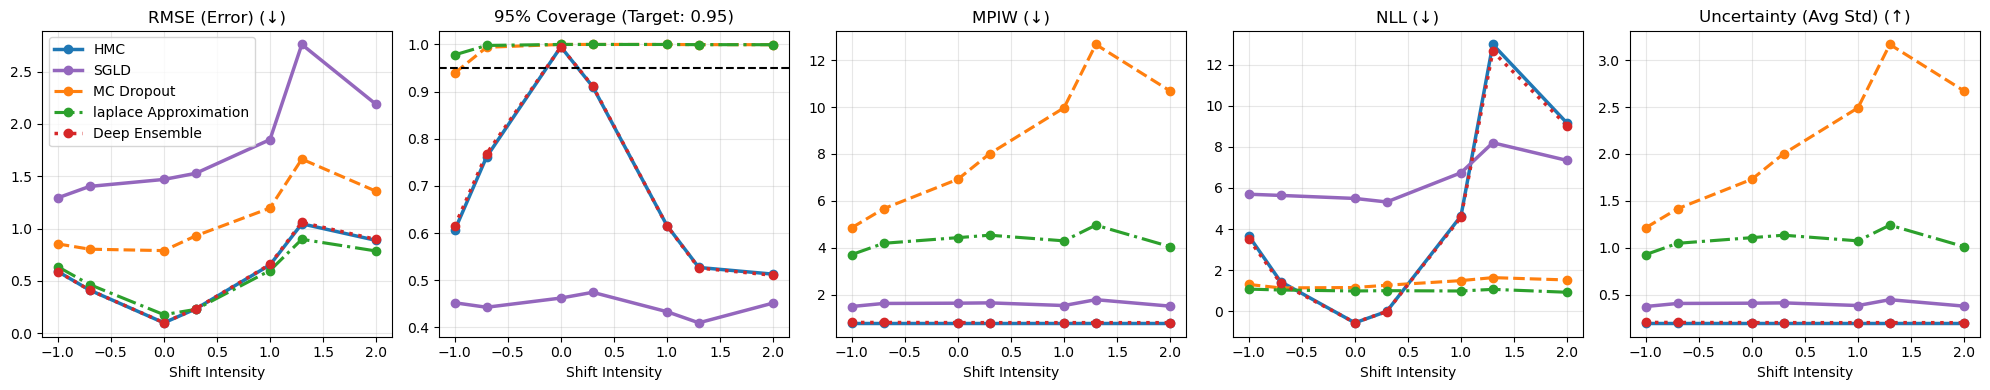

In [20]:
method = ['HMC', 'SGLD', 'MC Dropout', 'laplace Approximation', 'Deep Ensemble']
levels = [-1, -0.7, 0, 0.3, 1, 1.3, 2]
results_shifting_copy = results_shifting.copy()
results_shifting_copy[:,0,:] = results_id
results_shifting_copy[:,[2,0,1],:] = results_shifting_copy[:,[0,1,2],:]
uq_eval.run_regression_shift(method, levels, results_shifting_copy)

### Robustness check

In [21]:
uq_eval.comparison_uq(results_shifting[:,0,:], method)


Metric                             HMC         SGLD   MC Dropout laplace Approximation
-------------------------------------------------------------------------------------
RMSE                            0.1112       1.5206       0.8081     0.1896
Coverage 1σ (%)                  93.66        22.67       100.00     100.00
Coverage 2σ (%)                  99.35        43.06       100.00     100.00
Coverage 3σ (%)                  99.85        60.90       100.00     100.00
MPIW                            0.8000       1.6636       7.0377     4.5334
NLL                            -0.5360       5.8014       1.1733     1.0110


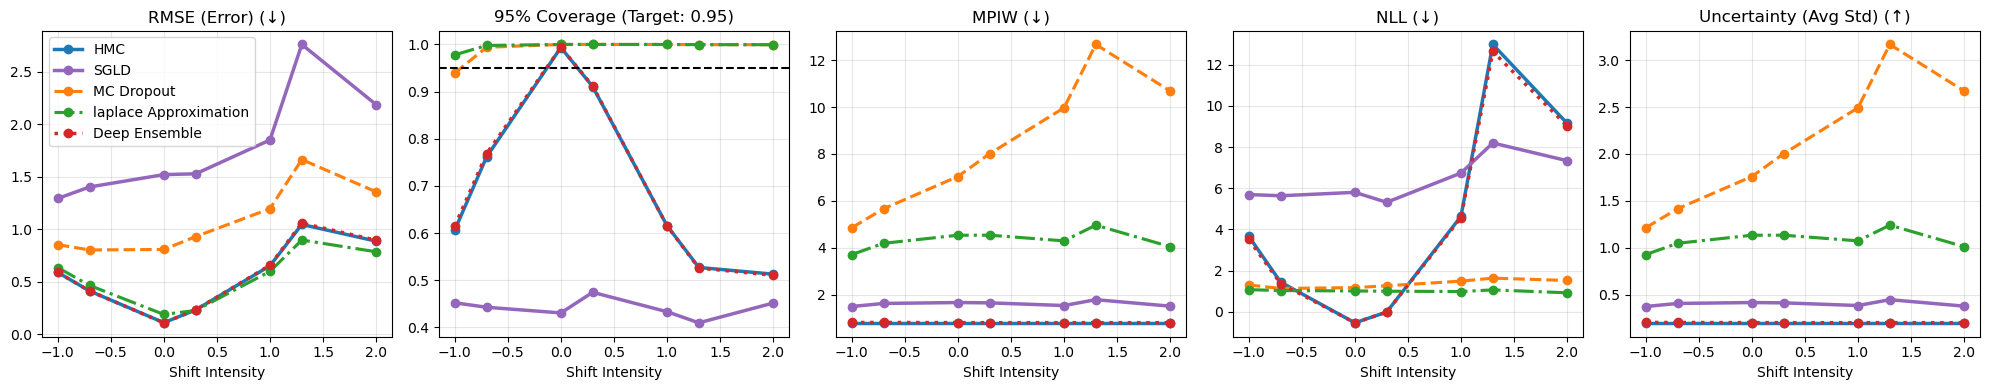

In [22]:
method = ['HMC', 'SGLD', 'MC Dropout', 'laplace Approximation', 'Deep Ensemble']
levels = [-1, -0.7, 0, 0.3, 1, 1.3, 2]
results_shifting_copy = results_shifting.copy()
results_shifting_copy[:,[2,0,1],:] = results_shifting_copy[:,[0,1,2],:]
uq_eval.run_regression_shift(method, levels, results_shifting_copy)

## OOD data detection

Method: HMC, Data: 0.005 -> AUROC: 0.5101
Method: HMC, Data: 0.0005 -> AUROC: 0.2894
Method: HMC, Data: 0.001 -> AUROC: 0.4098
Method: HMC, Data: 0.01 -> AUROC: 0.4891
Method: HMC, Data: 0.05 -> AUROC: 0.4022
Method: HMC, Data: 0.1 -> AUROC: 0.4356
Method: HMC, Data: 0.5 -> AUROC: 0.3622
Method: SGLD, Data: 0.005 -> AUROC: 0.5248
Method: SGLD, Data: 0.0005 -> AUROC: 0.3673
Method: SGLD, Data: 0.001 -> AUROC: 0.5101
Method: SGLD, Data: 0.01 -> AUROC: 0.4672
Method: SGLD, Data: 0.05 -> AUROC: 0.3301
Method: SGLD, Data: 0.1 -> AUROC: 0.3820
Method: SGLD, Data: 0.5 -> AUROC: 0.3123
Method: MC Dropout, Data: 0.005 -> AUROC: 0.5119
Method: MC Dropout, Data: 0.0005 -> AUROC: 0.2397
Method: MC Dropout, Data: 0.001 -> AUROC: 0.3549
Method: MC Dropout, Data: 0.01 -> AUROC: 0.5749
Method: MC Dropout, Data: 0.05 -> AUROC: 0.6287
Method: MC Dropout, Data: 0.1 -> AUROC: 0.6363
Method: MC Dropout, Data: 0.5 -> AUROC: 0.6058
Method: laplace Approximation, Data: 0.005 -> AUROC: 0.5318
Method: laplace A

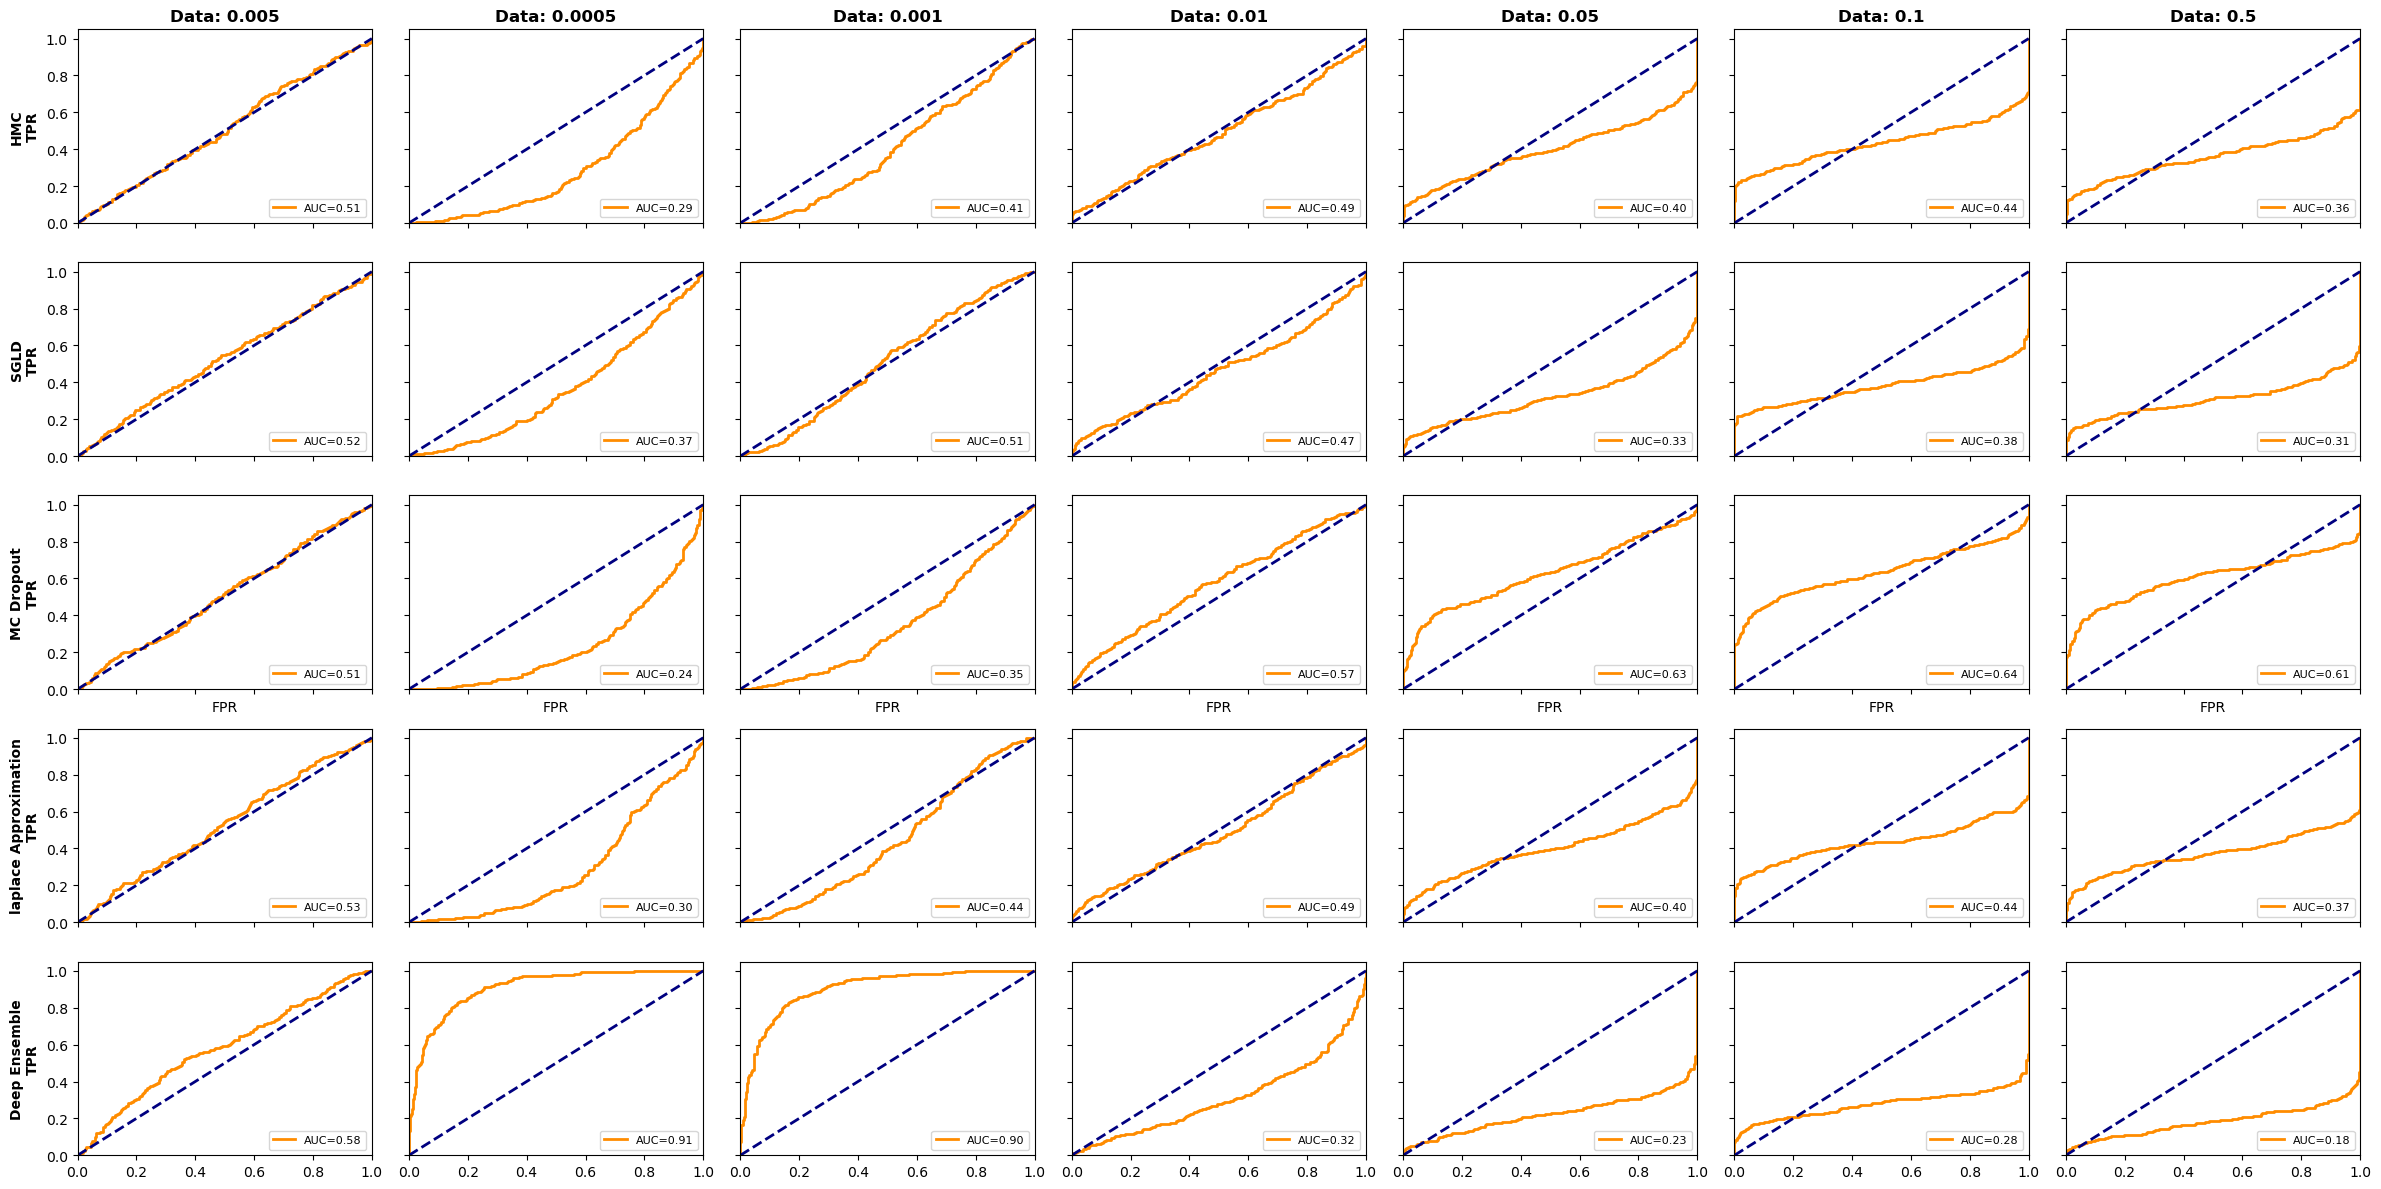

In [23]:
uq_methods_list = ['HMC', 'SGLD', 'MC Dropout', 'laplace Approximation', 'Deep Ensemble']
datatypes = [0.005, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.5]
fig, axes = plt.subplots(nrows=5, ncols=7, figsize=(24, 12), sharex=True, sharey=True)
for i, uqmethod in enumerate(uq_methods_list):     
    for j, dt in enumerate(datatypes):
        ax = axes[i, j]
        ood = np.concatenate((std_id[i], std_shifting[i][j]), axis = 0)
        ood = ood / np.max(ood)
        oods = np.concatenate((np.zeros(std_id[i].shape[0]), np.ones(std_shifting[i][j].shape[0])), axis = 0)
        auroc = roc_auc_score(oods, ood)
        fpr, tpr, _ = roc_curve(oods, ood)
        print(f"Method: {uqmethod}, Data: {dt} -> AUROC: {auroc:.4f}")
        ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC={auroc:.2f}')
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        if i == 0:
            ax.set_title(f"Data: {dt}", fontsize=12, fontweight='bold')
        if j == 0:
            ax.set_ylabel(f"{uqmethod}\nTPR", fontsize=10, fontweight='bold')
        else:
            ax.set_ylabel("")
        if i == 2:
            ax.set_xlabel('FPR')
        ax.legend(loc='lower right', fontsize=8)

plt.tight_layout()
plt.show()

## Conformal Prediction

In [24]:
model = torch.load(model_save_file, weights_only=False)
model.to(device)
alpha = 0.1  # Target error rate (90% coverage)
n_cal = 500  # Number of samples for calibration

# Split remaining test data into calibration and final test
indices = np.arange(num_test)
np.random.shuffle(indices)
cal_idx = indices[:n_cal]
test_idx = indices[n_cal:]

# Get predictions for calibration set
x_branch_cal = test_data['X_train'][cal_idx]
x_trunk_cal = test_data['X_trunk']
y_cal = test_data['Y_train'][cal_idx]

with torch.no_grad():
    x_b = torch.from_numpy(x_branch_cal).float().to(device)
    x_t = torch.from_numpy(x_trunk_cal).float().to(device)
    y_cal_pred = model.predict(x_b, x_t).cpu().numpy()

# Calculate non-conformity scores (Absolute Residuals)
# For vector outputs, we use point-wise absolute error
scores = np.abs(y_cal - y_cal_pred)

# Compute the (1-alpha) quantile of the scores
q_level = np.ceil((n_cal + 1) * (1 - alpha)) / n_cal
qhat = np.quantile(scores, q_level, axis=0) # Point-wise quantile

print(f"Calibration complete using {n_cal} samples.")
print(f"Quantile (qhat) mean value: {qhat.mean():.4f}")

Calibration complete using 500 samples.
Quantile (qhat) mean value: 0.1473


Results for alpha = 0.1 (Target Coverage: 90.0%)
Empirical Test Coverage: 88.4%
ID Coverage: 90.6%
OOD Coverage: 85.7%
Average Prediction Interval Width: 0.2946
AUROC of 0.005 for OOD detection: 0.720205
Results for alpha = 0.1 (Target Coverage: 90.0%)
Empirical Test Coverage: 62.7%
ID Coverage: 90.6%
OOD Coverage: 27.8%
Average Prediction Interval Width: 0.2946
AUROC of 0.0005 for OOD detection: 1.0
Results for alpha = 0.1 (Target Coverage: 90.0%)
Empirical Test Coverage: 66.7%
ID Coverage: 90.6%
OOD Coverage: 36.9%
Average Prediction Interval Width: 0.2946
AUROC of 0.001 for OOD detection: 0.99993
Results for alpha = 0.1 (Target Coverage: 90.0%)
Empirical Test Coverage: 75.7%
ID Coverage: 90.6%
OOD Coverage: 57.1%
Average Prediction Interval Width: 0.2946
AUROC of 0.01 for OOD detection: 0.9814425
Results for alpha = 0.1 (Target Coverage: 90.0%)
Empirical Test Coverage: 61.6%
ID Coverage: 90.6%
OOD Coverage: 25.4%
Average Prediction Interval Width: 0.2946
AUROC of 0.05 for OOD detect

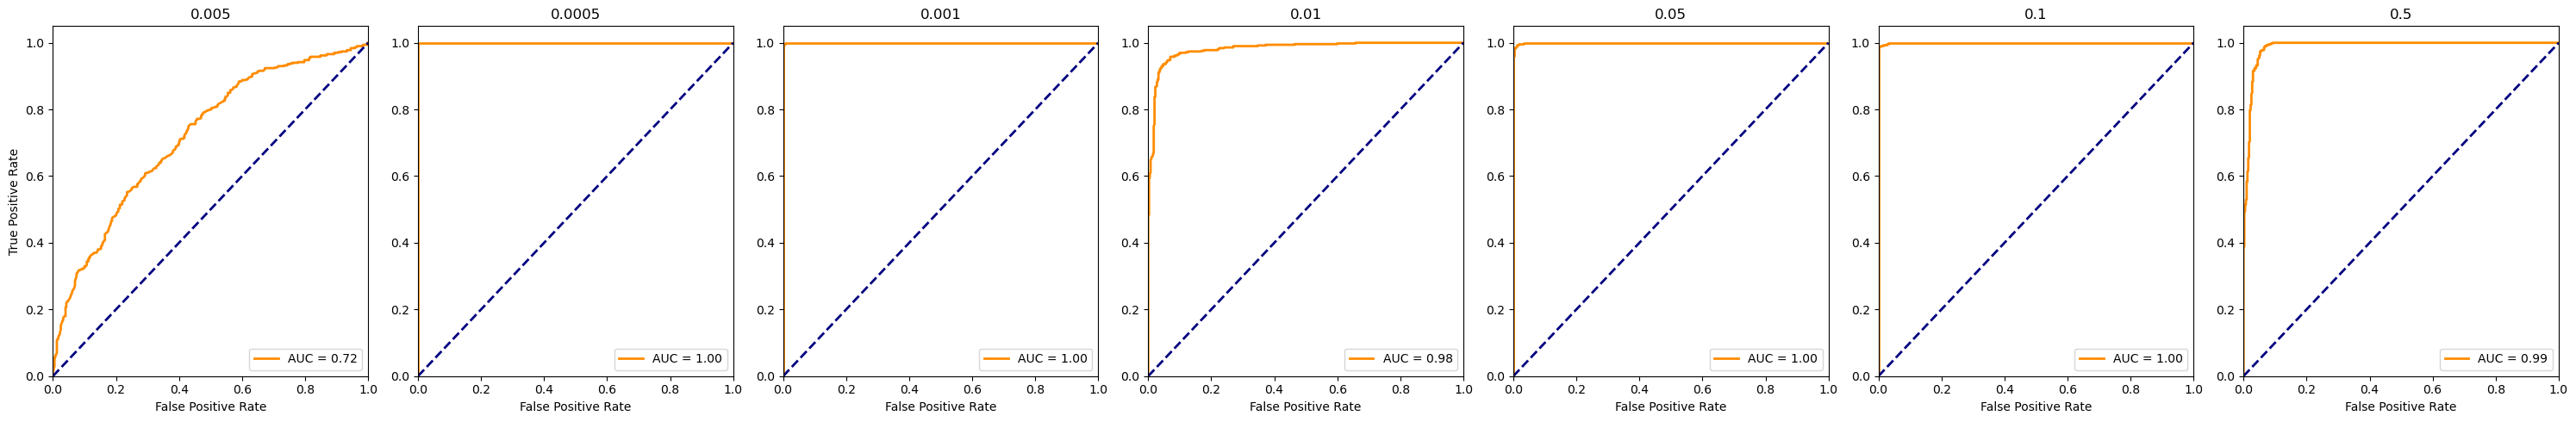

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(30, 5)) 
for i, datatype in enumerate(datatypes):
    
    ax = axes[i]
    # Evaluate on the remaining test set
    x_branch_final = np.concatenate((test_data['X_train'][test_idx], data_shifting_data[i]['X_train']), axis=0) 
    y_test_final = np.concatenate((test_data['Y_train'][test_idx], data_shifting_data[i]['Y_train']), axis=0) 

    with torch.no_grad():
        x_b_final = torch.from_numpy(x_branch_final).float().to(device)
        y_test_pred = model.predict(x_b_final, x_t).cpu().numpy()

    # Prediction Intervals: [pred - qhat, pred + qhat]
    lower_bound = y_test_pred - qhat
    upper_bound = y_test_pred + qhat

    # Calculate empirical coverage
    cover = ((y_test_final >= lower_bound) & (y_test_final <= upper_bound)).mean(axis=1)
    coverage = cover.mean()
    cover_id = cover[:len(test_idx)]
    cover_ood = cover[len(test_idx):]
    cover_id_mean = cover_id.mean() 
    cover_ood_mean = cover_ood.mean()

    print(f"Results for alpha = {alpha} (Target Coverage: {1-alpha:.1%})")
    print(f"Empirical Test Coverage: {coverage:.1%}")
    print(f"ID Coverage: {cover_id_mean:.1%}")
    print(f"OOD Coverage: {cover_ood_mean:.1%}")
    print(f"Average Prediction Interval Width: {(upper_bound - lower_bound).mean():.4f}")


    oods = np.concatenate((np.ones(len(test_idx)), np.zeros(len(x_branch_final)-len(test_idx))), axis=0)

    auroc = roc_auc_score(oods, cover)
    fpr, tpr, _ = roc_curve(oods, cover)
    
    print(f"AUROC of {datatype} for OOD detection: {auroc}")

    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auroc:.2f}')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
 
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    ax.set_xlabel('False Positive Rate')

    if i == 0:
        ax.set_ylabel('True Positive Rate')
    
    ax.set_title(f'{datatype}')
    ax.legend(loc='lower right')

plt.tight_layout()
plt.show()